In [25]:

# Author Yang Xiang, Date 2024 12 30.
# All the group members have been added to the project
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib as mp
import seaborn as sns
import matplotlib.pyplot as plt  # 
import scipy as sp
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import squareform
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os


## Part 1: Data cleaning, adding -1 for numerical missing values, and "NA" string value
## for categorical missing values.
new_path = "D:\课堂练习"  # 替换为你想要设置的路径
os.chdir(new_path)
train = pd.read_csv('train.csv')
# This is for test purpose to fix


ID                       0
dri_score                0
psych_disturb            0
cyto_score               0
diabetes                 0
                        ..
peptic_ulcer_encoded     0
rheum_issue_encoded      0
hepatic_mild_encoded     0
cardiac_encoded          0
pulm_moderate_encoded    0
Length: 77, dtype: int64


In [26]:

# 定义需要转换的列
columns_to_encode = [
    'psych_disturb', 'diabetes', 'arrhythmia', 'renal_issue', 'pulm_severe', 
    'rituximab', 'obesity', 'in_vivo_tcd', 'hepatic_severe', 'prior_tumor', 
    'peptic_ulcer', 'rheum_issue', 'hepatic_mild', 'cardiac', 'pulm_moderate'
]

# 将 Yes/No 转换为 1/0
for col in columns_to_encode:
    train[col] = train[col].replace({'Yes': 1, 'No': 0})

C:\Users\86198\AppData\Local\Temp\ipykernel_9232\800752416.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train[col] = train[col].replace({'Yes': 1, 'No': 0})


In [27]:

columns_to_encode = [
    'dri_score', 'cyto_score', 'tbi_status', 'graft_type', 'prim_disease_hct', 
    'cmv_status', 'tce_imm_match', 'prod_type', 'cyto_score_detail', 
    'conditioning_intensity', 'mrd_hct', 'tce_match', 'gvhd_proph', 
    'sex_match', 'race_group', 'tce_div_match', 'melphalan_dose','vent_hist', 'ethnicity'
]

# 初始化 OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# 对指定列进行独热编码
encoded_data = encoder.fit_transform(train[columns_to_encode])

# 获取编码后的列名
encoded_column_names = encoder.get_feature_names_out(columns_to_encode)

# 将编码后的数据转换为 DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names)

# 将编码后的数据合并回原始 DataFrame
data = pd.concat([train.drop(columns=columns_to_encode), encoded_df], axis=1)

# 查看生成的新变量
print("Encoded Column Names:")
print(encoded_column_names)


Encoded Column Names:
['dri_score_High - TED AML case <missing cytogenetics'
 'dri_score_Intermediate'
 'dri_score_Intermediate - TED AML case <missing cytogenetics'
 'dri_score_Low' 'dri_score_Missing disease status'
 'dri_score_N/A - disease not classifiable'
 'dri_score_N/A - non-malignant indication' 'dri_score_N/A - pediatric'
 'dri_score_TBD cytogenetics' 'dri_score_Very high' 'dri_score_nan'
 'cyto_score_Intermediate' 'cyto_score_Normal' 'cyto_score_Not tested'
 'cyto_score_Other' 'cyto_score_Poor' 'cyto_score_TBD' 'cyto_score_nan'
 'tbi_status_TBI + Cy +- Other'
 'tbi_status_TBI +- Other, -cGy, fractionated'
 'tbi_status_TBI +- Other, -cGy, single'
 'tbi_status_TBI +- Other, -cGy, unknown dose'
 'tbi_status_TBI +- Other, <=cGy' 'tbi_status_TBI +- Other, >cGy'
 'tbi_status_TBI +- Other, unknown dose' 'graft_type_Peripheral blood'
 'prim_disease_hct_ALL' 'prim_disease_hct_AML' 'prim_disease_hct_CML'
 'prim_disease_hct_HD' 'prim_disease_hct_HIS' 'prim_disease_hct_IEA'
 'prim_disea

In [28]:
print(data.columns)
with open("column_names.txt", "w") as file:
    for col in data.columns:
        file.write(col + "\n")

print("Column names have been saved to 'column_names.txt'.")

Index(['ID', 'psych_disturb', 'diabetes', 'hla_match_c_high', 'hla_high_res_8',
       'arrhythmia', 'hla_low_res_6', 'renal_issue', 'pulm_severe',
       'hla_high_res_6',
       ...
       'tce_div_match_HvG non-permissive',
       'tce_div_match_Permissive mismatched', 'tce_div_match_nan',
       'melphalan_dose_N/A, Mel not given', 'melphalan_dose_nan',
       'vent_hist_Yes', 'vent_hist_nan', 'ethnicity_Non-resident of the U.S.',
       'ethnicity_Not Hispanic or Latino', 'ethnicity_nan'],
      dtype='object', length=151)
Column names have been saved to 'column_names.txt'.


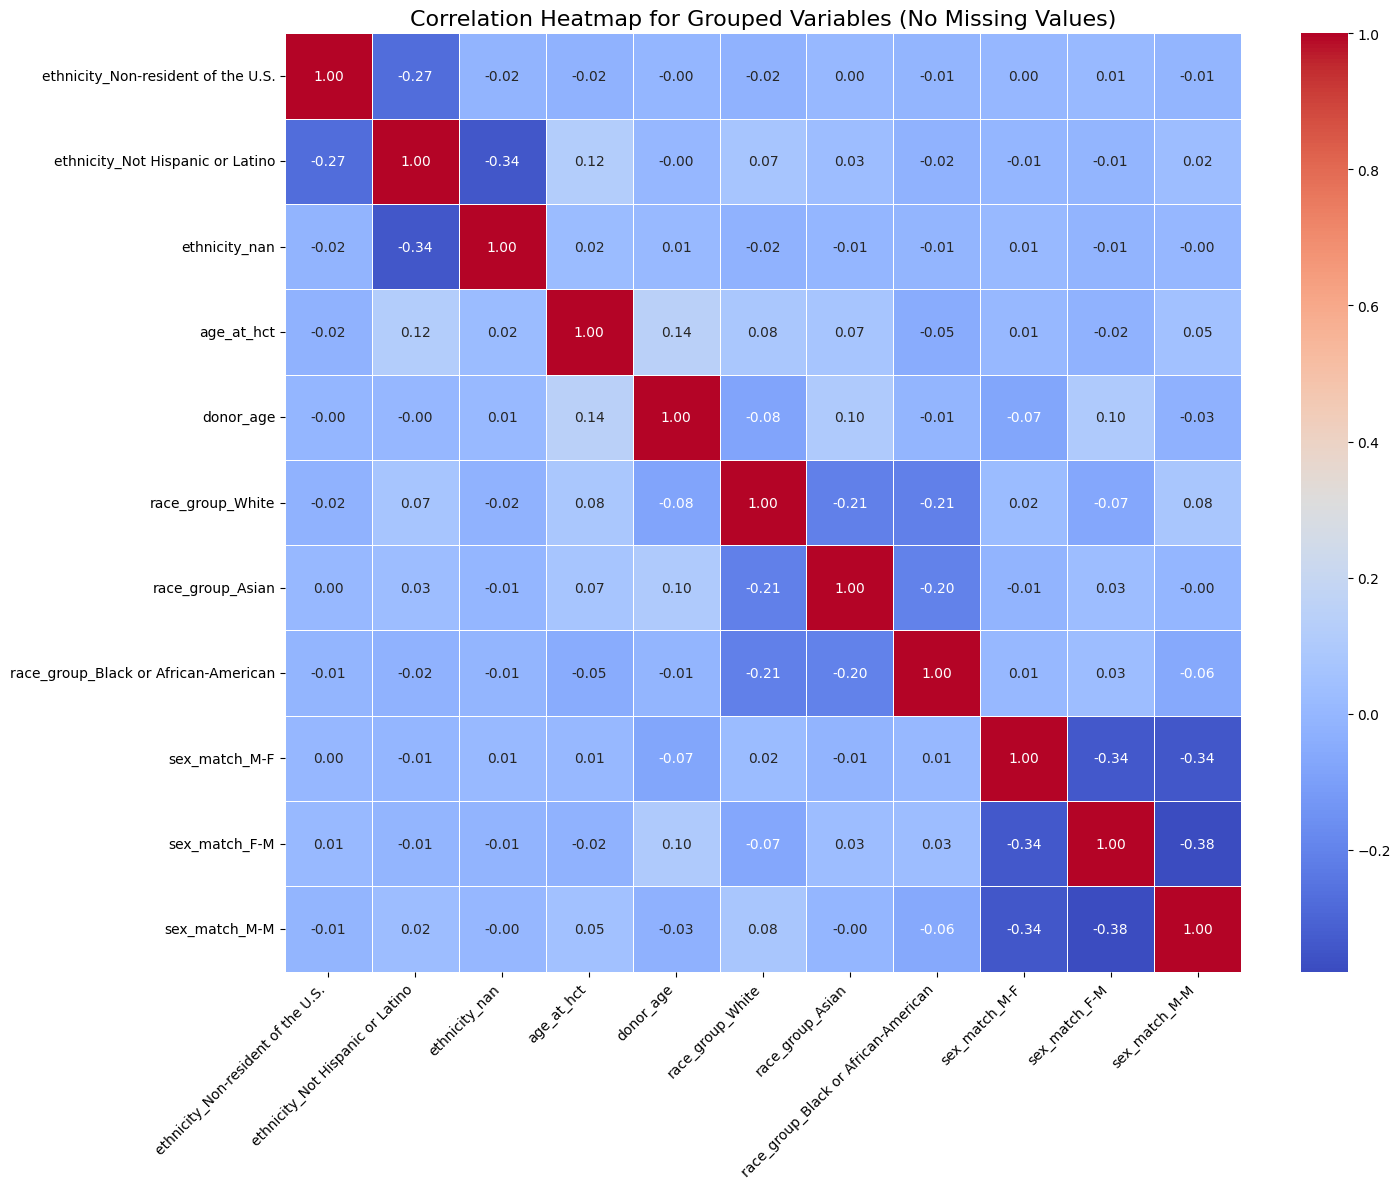

In [15]:

group_columns = [
    'ethnicity_Non-resident of the U.S.',
    'ethnicity_Not Hispanic or Latino', 'ethnicity_nan', 'age_at_hct', 'donor_age', 
    'race_group_White', 'race_group_Asian', 'race_group_Black or African-American',
    'sex_match_M-F', 'sex_match_F-M', 'sex_match_M-M'
]

# 删除包含 'Not done' 的行
data = data[~data.isin(['Not done']).any(axis=1)]

# 检查分组变量中是否有缺失值
data['gen'] = data[group_columns].isnull().any(axis=1).astype(int)

# 过滤数据：只保留没有缺失值的行
filtered_data = data[data['gen'] == 0].drop(columns=['gen'])

# 确保所有列都是数值型
filtered_data = filtered_data[group_columns].select_dtypes(include=['number'])

# 计算相关性矩阵
correlation_matrix = filtered_data.corr()

# 绘制热力图
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title("Correlation Heatmap for Grouped Variables (No Missing Values)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\86198\AppData\Local\Temp\ipykernel_9232\2499825597.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=efs_corr.index, y=efs_corr.values, palette="viridis")


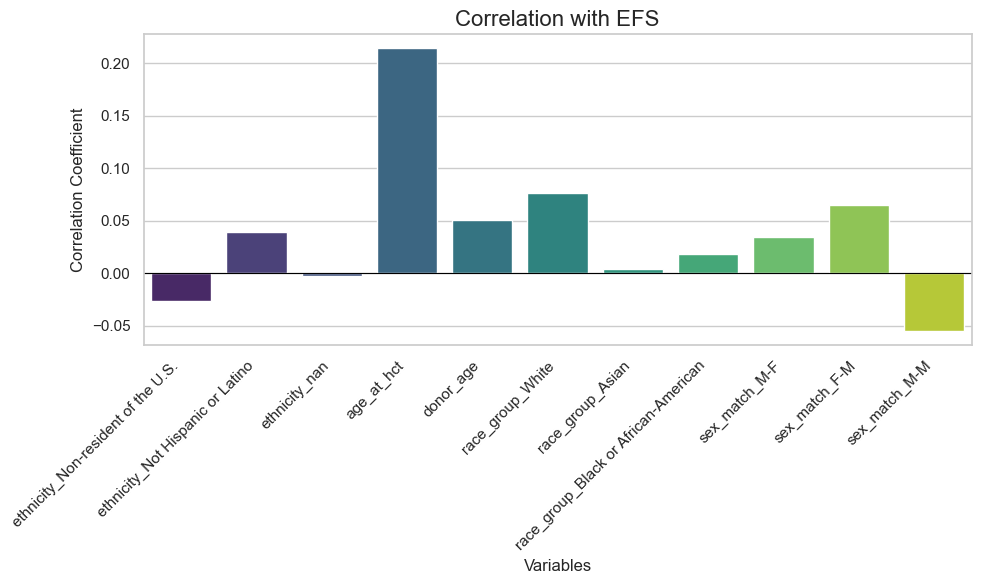

C:\Users\86198\AppData\Local\Temp\ipykernel_9232\2499825597.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=efs_time_corr.index, y=efs_time_corr.values, palette="viridis")


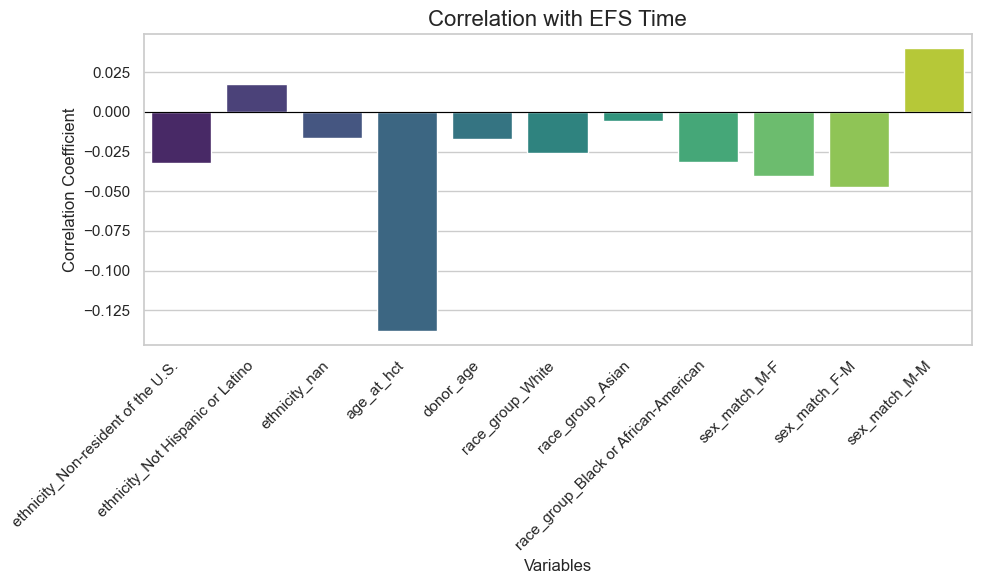

In [16]:
# 计算与 efs 的相关性
efs_corr = filtered_data[group_columns].corrwith(train['efs'])

# 计算与 efs_time 的相关性
efs_time_corr = filtered_data[group_columns].corrwith(train['efs_time'])



# 设置图形风格
sns.set(style="whitegrid")

# 绘制 efs 相关性图
plt.figure(figsize=(10, 6))
sns.barplot(x=efs_corr.index, y=efs_corr.values, palette="viridis")
plt.axhline(0, color="black", linewidth=0.8)  # 添加水平参考线
plt.title("Correlation with EFS", fontsize=16)
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 绘制 efs_time 相关性图
plt.figure(figsize=(10, 6))
sns.barplot(x=efs_time_corr.index, y=efs_time_corr.values, palette="viridis")
plt.axhline(0, color="black", linewidth=0.8)  # 添加水平参考线
plt.title("Correlation with EFS Time", fontsize=16)
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

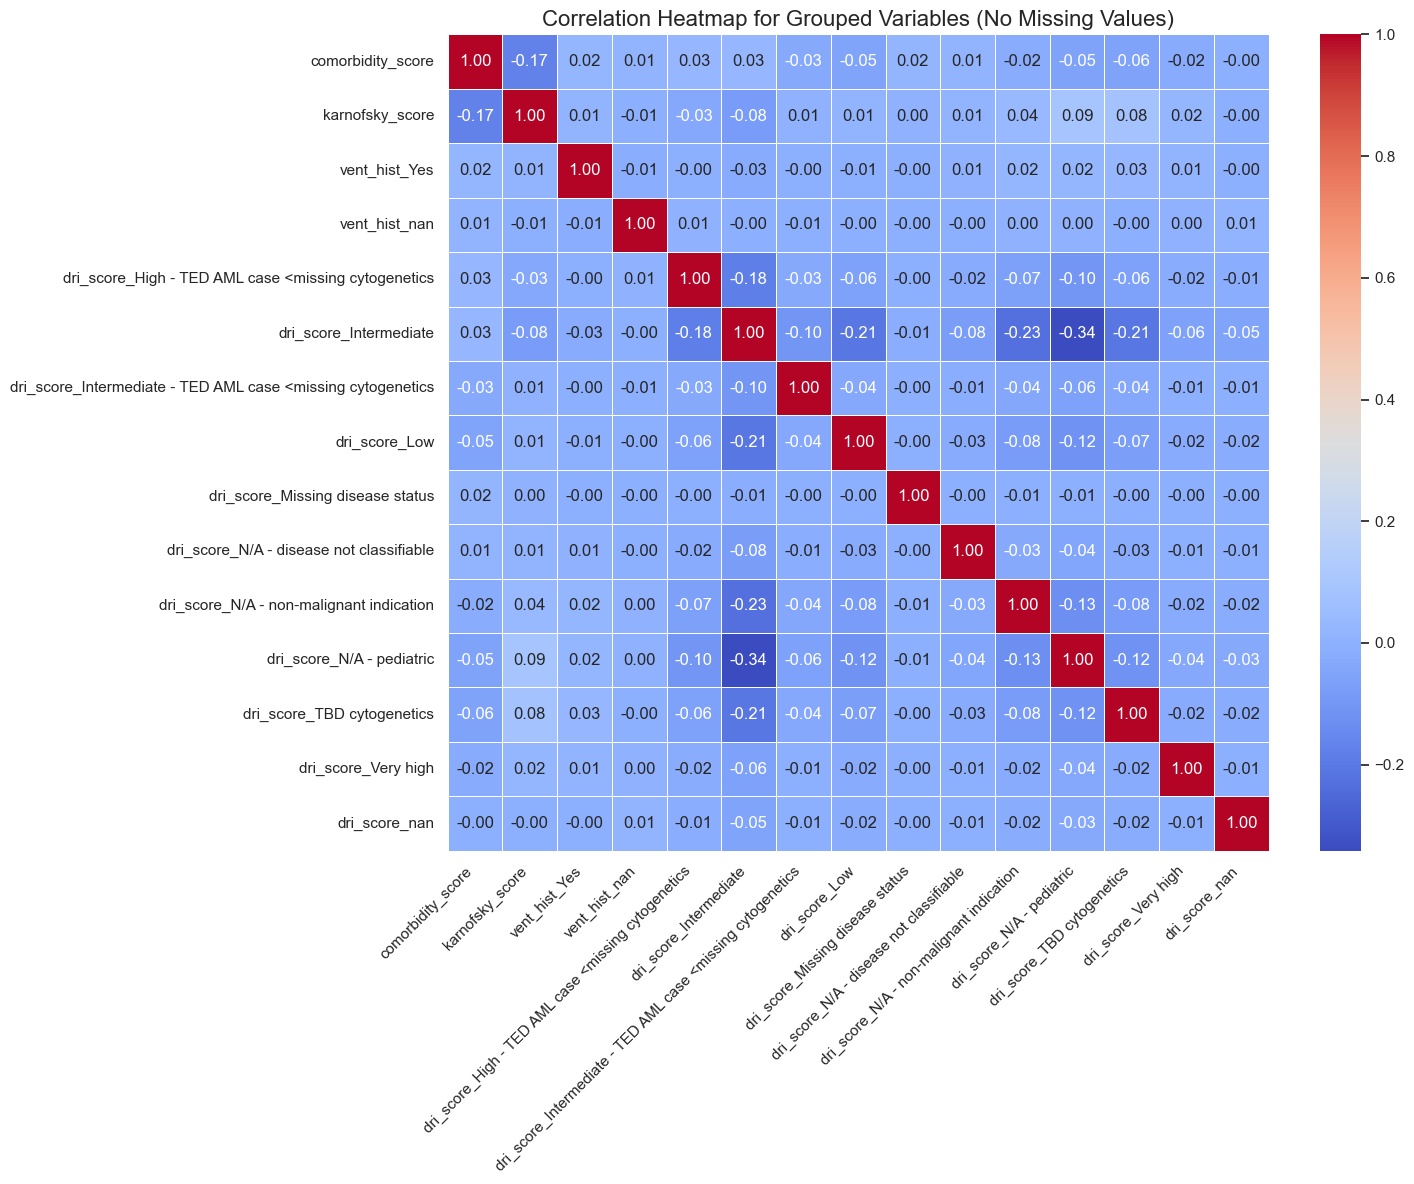

In [21]:


group_columns = [
    'comorbidity_score', 'karnofsky_score', 'diabetes', 'obesity', 'prior_tumor',
    'hepatic_severe', 'hepatic_mild', 'renal_issue', 'pulm_severe', 'pulm_moderate',
    'cardiac', 'arrhythmia', 'psych_disturb',  'vent_hist_Yes', 'vent_hist_nan' , 'peptic_ulcer', 'rheum_issue',
    'dri_score_High - TED AML case <missing cytogenetics',
    'dri_score_Intermediate',
    'dri_score_Intermediate - TED AML case <missing cytogenetics',
    'dri_score_Low',
    'dri_score_Missing disease status',
    'dri_score_N/A - disease not classifiable',
    'dri_score_N/A - non-malignant indication',
    'dri_score_N/A - pediatric',
    'dri_score_TBD cytogenetics',
    'dri_score_Very high',
    'dri_score_nan'
]

# 删除包含 'Not done' 的行
data = data[~data.isin(['Not done']).any(axis=1)]

# 检查分组变量中是否有缺失值
data['gen'] = data[group_columns].isnull().any(axis=1).astype(int)

# 过滤数据：只保留没有缺失值的行
filtered_data = data[data['gen'] == 0].drop(columns=['gen'])

# 确保所有列都是数值型
filtered_data = filtered_data[group_columns].select_dtypes(include=['number'])

# 检查是否所有列都成功转换为数值型
if len(filtered_data.columns) != len(group_columns):
    missing_columns = [col for col in group_columns if col not in filtered_data.columns]
    print(f"Warning: Some columns were not included due to non-numeric data: {missing_columns}")

# 计算相关性矩阵
correlation_matrix = filtered_data.corr()

# 绘制热力图
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title("Correlation Heatmap for Grouped Variables (No Missing Values)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [31]:
# 将分类变量转换为数值型
for col in ['diabetes', 'obesity', 'prior_tumor', 'hepatic_severe', 'hepatic_mild', 
            'renal_issue', 'pulm_severe', 'pulm_moderate', 'cardiac', 'arrhythmia', 
            'psych_disturb', 'peptic_ulcer', 'rheum_issue']:
    if col in filtered_data.columns:
        filtered_data[col] = filtered_data[col].astype(int)  # 假设是 0/1 变量
        # 将字符串分类变量转换为数值型
for col in ['diabetes', 'obesity', 'prior_tumor', 'hepatic_severe', 'hepatic_mild', 
            'renal_issue', 'pulm_severe', 'pulm_moderate', 'cardiac', 'arrhythmia', 
            'psych_disturb', 'peptic_ulcer', 'rheum_issue']:
    if col in filtered_data.columns:
        filtered_data[col] = filtered_data[col].map({'Yes': 1, 'No': 0})  # 假设是 Yes/No 变量
        

In [33]:
# 检查 efs 和 efs_time 是否存在
if 'efs' not in filtered_data.columns or 'efs_time' not in filtered_data.columns:
    print("错误：'efs' 或 'efs_time' 列不存在。请检查数据加载或预处理步骤。")
else:
    # 继续计算相关性
    pass

错误：'efs' 或 'efs_time' 列不存在。请检查数据加载或预处理步骤。


C:\Users\86198\AppData\Local\Temp\ipykernel_9232\889303837.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=efs_corr.index, y=efs_corr.values, palette="viridis")


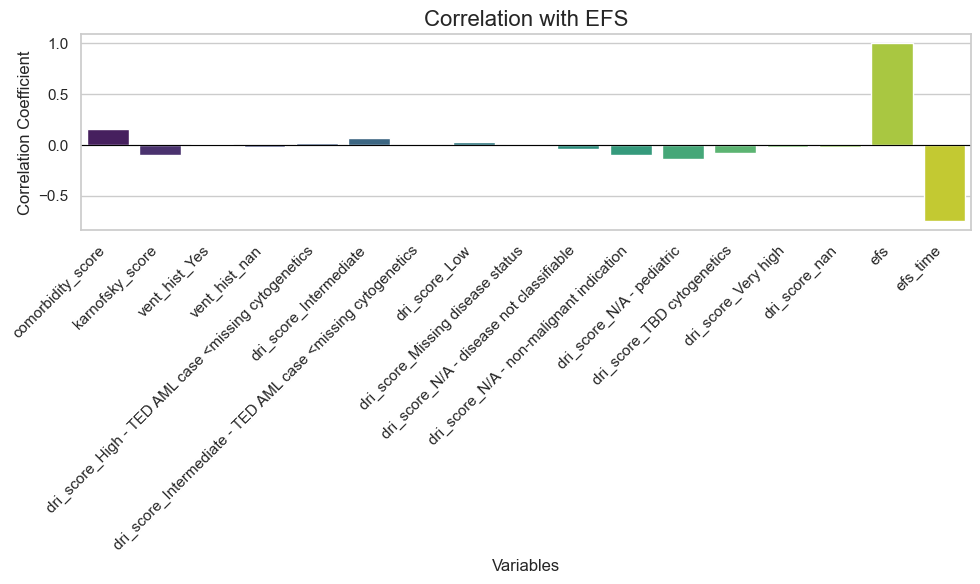

C:\Users\86198\AppData\Local\Temp\ipykernel_9232\889303837.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=efs_time_corr.index, y=efs_time_corr.values, palette="viridis")


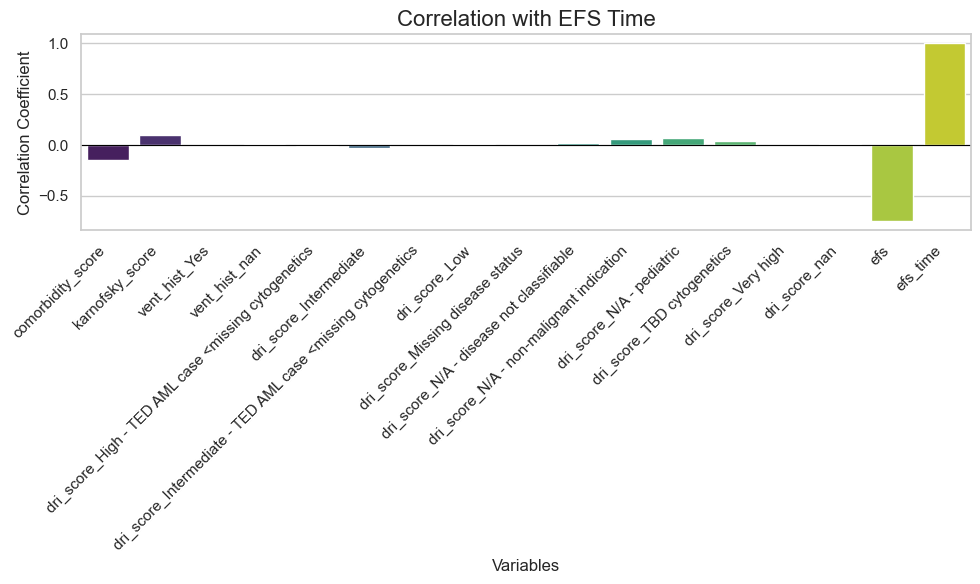

In [36]:


# 定义 group_columns
group_columns = [
    'comorbidity_score', 'karnofsky_score', 
  'vent_hist_Yes', 'vent_hist_nan' ,  
    'dri_score_High - TED AML case <missing cytogenetics',
    'dri_score_Intermediate',
    'dri_score_Intermediate - TED AML case <missing cytogenetics',
    'dri_score_Low',
    'dri_score_Missing disease status',
    'dri_score_N/A - disease not classifiable',
    'dri_score_N/A - non-malignant indication',
    'dri_score_N/A - pediatric',
    'dri_score_TBD cytogenetics',
    'dri_score_Very high',
    'dri_score_nan','efs','efs_time'
]

# 删除包含 'Not done' 的行
data = data[~data.isin(['Not done']).any(axis=1)]

# 检查分组变量中是否有缺失值
data['gen'] = data[group_columns].isnull().any(axis=1).astype(int)

# 过滤数据：只保留没有缺失值的行
filtered_data = data[data['gen'] == 0].drop(columns=['gen'])

# 确保所有列都是数值型
filtered_data = filtered_data[group_columns].select_dtypes(include=['number'])

# 检查是否所有列都成功转换为数值型
if len(filtered_data.columns) != len(group_columns):
    missing_columns = [col for col in group_columns if col not in filtered_data.columns]
    print(f"Warning: Some columns were not included due to non-numeric data: {missing_columns}")

# 检查 efs 和 efs_time 是否存在
if 'efs' not in filtered_data.columns or 'efs_time' not in filtered_data.columns:
    print("错误：'efs' 或 'efs_time' 列不存在。")
else:
    # 计算与 efs 的相关性
    efs_corr = filtered_data[group_columns].corrwith(filtered_data['efs'])

    # 计算与 efs_time 的相关性
    efs_time_corr = filtered_data[group_columns].corrwith(filtered_data['efs_time'])

    # 设置图形风格
    sns.set(style="whitegrid")

    # 绘制 efs 相关性图
    plt.figure(figsize=(10, 6))
    sns.barplot(x=efs_corr.index, y=efs_corr.values, palette="viridis")
    plt.axhline(0, color="black", linewidth=0.8)  # 添加水平参考线
    plt.title("Correlation with EFS", fontsize=16)
    plt.xlabel("Variables", fontsize=12)
    plt.ylabel("Correlation Coefficient", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # 绘制 efs_time 相关性图
    plt.figure(figsize=(10, 6))
    sns.barplot(x=efs_time_corr.index, y=efs_time_corr.values, palette="viridis")
    plt.axhline(0, color="black", linewidth=0.8)  # 添加水平参考线
    plt.title("Correlation with EFS Time", fontsize=16)
    plt.xlabel("Variables", fontsize=12)
    plt.ylabel("Correlation Coefficient", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

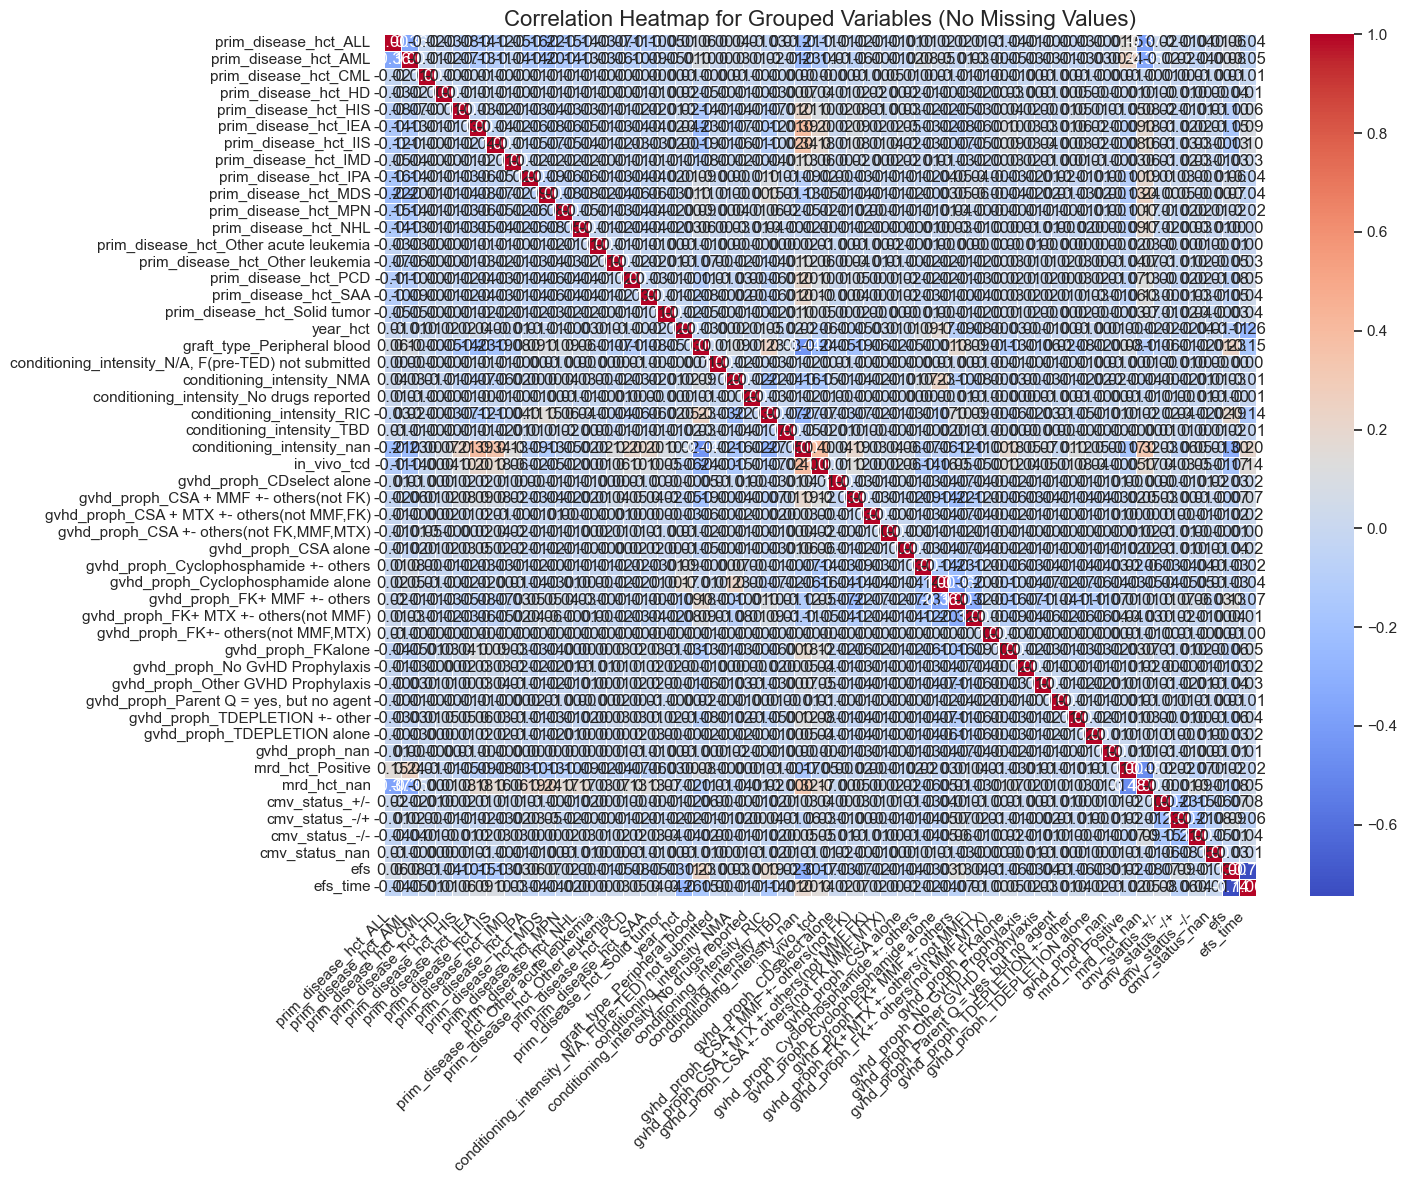

In [37]:
group_columns = [
     'prim_disease_hct_ALL',
    'prim_disease_hct_AML',
    'prim_disease_hct_CML',
    'prim_disease_hct_HD',
    'prim_disease_hct_HIS',
    'prim_disease_hct_IEA',
    'prim_disease_hct_IIS',
    'prim_disease_hct_IMD',
    'prim_disease_hct_IPA',
    'prim_disease_hct_MDS',
    'prim_disease_hct_MPN',
    'prim_disease_hct_NHL',
    'prim_disease_hct_Other acute leukemia',
    'prim_disease_hct_Other leukemia',
    'prim_disease_hct_PCD',
    'prim_disease_hct_SAA',
    'prim_disease_hct_Solid tumor',
    'year_hct',
    'graft_type_Peripheral blood',
    'conditioning_intensity_N/A, F(pre-TED) not submitted',
    'conditioning_intensity_NMA',
    'conditioning_intensity_No drugs reported',
    'conditioning_intensity_RIC',
    'conditioning_intensity_TBD',
    'conditioning_intensity_nan',
    'in_vivo_tcd',
     'gvhd_proph_CDselect alone',
    'gvhd_proph_CSA + MMF +- others(not FK)',
    'gvhd_proph_CSA + MTX +- others(not MMF,FK)',
    'gvhd_proph_CSA +- others(not FK,MMF,MTX)',
    'gvhd_proph_CSA alone',
    'gvhd_proph_Cyclophosphamide +- others',
    'gvhd_proph_Cyclophosphamide alone',
    'gvhd_proph_FK+ MMF +- others',
    'gvhd_proph_FK+ MTX +- others(not MMF)',
    'gvhd_proph_FK+- others(not MMF,MTX)',
    'gvhd_proph_FKalone',
    'gvhd_proph_No GvHD Prophylaxis',
    'gvhd_proph_Other GVHD Prophylaxis',
    'gvhd_proph_Parent Q = yes, but no agent',
    'gvhd_proph_TDEPLETION +- other',
    'gvhd_proph_TDEPLETION alone',
    'gvhd_proph_nan',
    'mrd_hct_Positive',
    'mrd_hct_nan',
    'cmv_status_+/-',
    'cmv_status_-/+',
    'cmv_status_-/-',
    'cmv_status_nan','efs','efs_time'
]

# 删除包含 'Not done' 的行
data = data[~data.isin(['Not done']).any(axis=1)]

# 检查分组变量中是否有缺失值
data['gen'] = data[group_columns].isnull().any(axis=1).astype(int)

# 过滤数据：只保留没有缺失值的行
filtered_data = data[data['gen'] == 0].drop(columns=['gen'])

# 确保所有列都是数值型
filtered_data = filtered_data[group_columns].select_dtypes(include=['number'])

# 检查是否所有列都成功转换为数值型
if len(filtered_data.columns) != len(group_columns):
    missing_columns = [col for col in group_columns if col not in filtered_data.columns]
    print(f"Warning: Some columns were not included due to non-numeric data: {missing_columns}")

# 计算相关性矩阵
correlation_matrix = filtered_data.corr()

# 绘制热力图
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title("Correlation Heatmap for Grouped Variables (No Missing Values)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\86198\AppData\Local\Temp\ipykernel_9232\4040851267.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=efs_corr.index, y=efs_corr.values, palette="viridis")


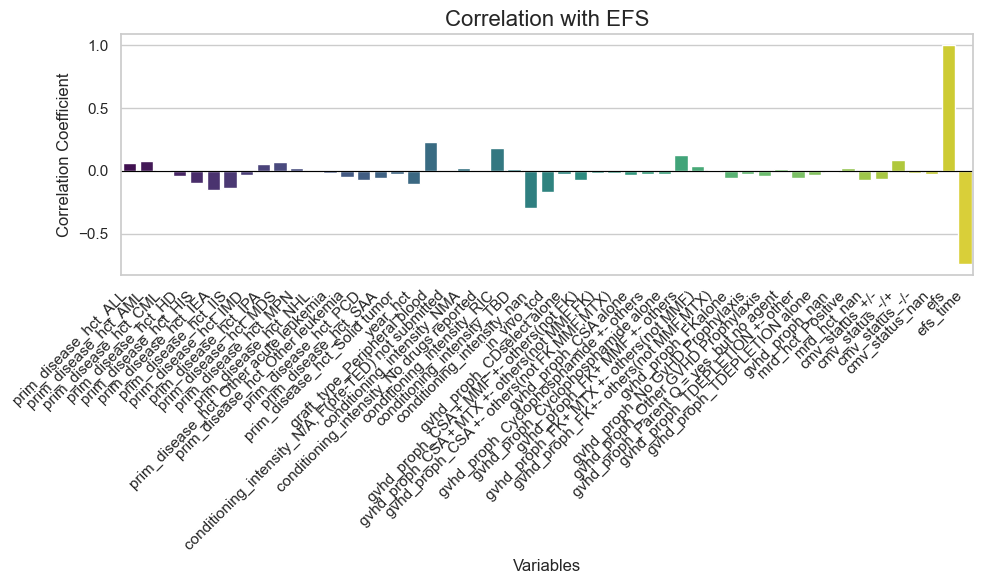

C:\Users\86198\AppData\Local\Temp\ipykernel_9232\4040851267.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=efs_time_corr.index, y=efs_time_corr.values, palette="viridis")


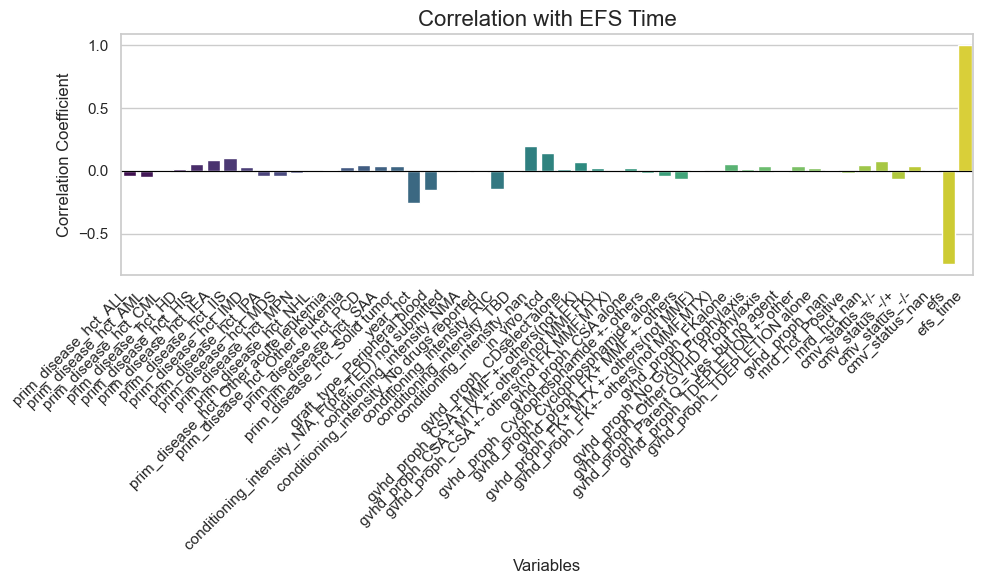

In [38]:

    # 计算与 efs 的相关性
    efs_corr = filtered_data[group_columns].corrwith(filtered_data['efs'])

    # 计算与 efs_time 的相关性
    efs_time_corr = filtered_data[group_columns].corrwith(filtered_data['efs_time'])

    # 设置图形风格
    sns.set(style="whitegrid")

    # 绘制 efs 相关性图
    plt.figure(figsize=(10, 6))
    sns.barplot(x=efs_corr.index, y=efs_corr.values, palette="viridis")
    plt.axhline(0, color="black", linewidth=0.8)  # 添加水平参考线
    plt.title("Correlation with EFS", fontsize=16)
    plt.xlabel("Variables", fontsize=12)
    plt.ylabel("Correlation Coefficient", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # 绘制 efs_time 相关性图
    plt.figure(figsize=(10, 6))
    sns.barplot(x=efs_time_corr.index, y=efs_time_corr.values, palette="viridis")
    plt.axhline(0, color="black", linewidth=0.8)  # 添加水平参考线
    plt.title("Correlation with EFS Time", fontsize=16)
    plt.xlabel("Variables", fontsize=12)
    plt.ylabel("Correlation Coefficient", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

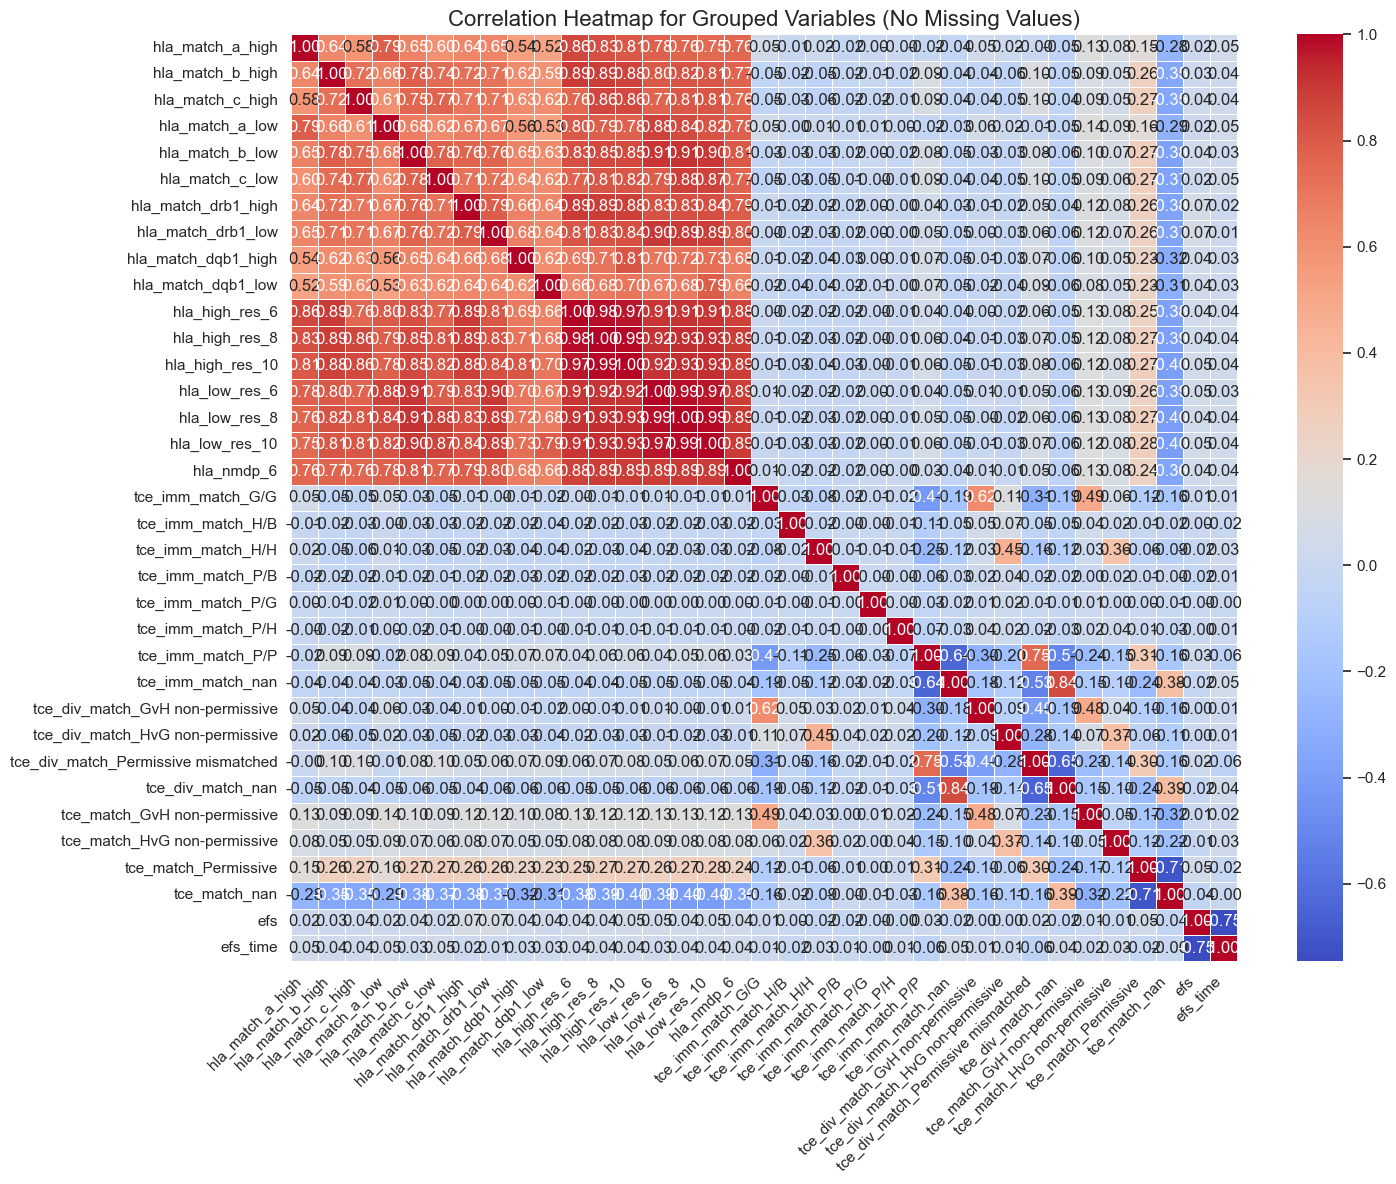

In [40]:
group_columns = [
     'hla_match_a_high',
    'hla_match_b_high',
    'hla_match_c_high',
    'hla_match_a_low',
    'hla_match_b_low',
    'hla_match_c_low',
    'hla_match_drb1_high',
    'hla_match_drb1_low',
    'hla_match_dqb1_high',
    'hla_match_dqb1_low',
    'hla_high_res_6',
    'hla_high_res_8',
    'hla_high_res_10',
    'hla_low_res_6',
    'hla_low_res_8',
    'hla_low_res_10',
    'hla_nmdp_6',
    'tce_imm_match_G/G',
    'tce_imm_match_H/B',
    'tce_imm_match_H/H',
    'tce_imm_match_P/B',
    'tce_imm_match_P/G',
    'tce_imm_match_P/H',
    'tce_imm_match_P/P',
    'tce_imm_match_nan',
    'tce_div_match_GvH non-permissive',
    'tce_div_match_HvG non-permissive',
    'tce_div_match_Permissive mismatched',
    'tce_div_match_nan',
    'tce_match_GvH non-permissive',
    'tce_match_HvG non-permissive',
    'tce_match_Permissive',
    'tce_match_nan','efs','efs_time'
]

# 删除包含 'Not done' 的行
data = data[~data.isin(['Not done']).any(axis=1)]

# 检查分组变量中是否有缺失值
data['gen'] = data[group_columns].isnull().any(axis=1).astype(int)

# 过滤数据：只保留没有缺失值的行
filtered_data = data[data['gen'] == 0].drop(columns=['gen'])

# 确保所有列都是数值型
filtered_data = filtered_data[group_columns].select_dtypes(include=['number'])

# 检查是否所有列都成功转换为数值型
if len(filtered_data.columns) != len(group_columns):
    missing_columns = [col for col in group_columns if col not in filtered_data.columns]
    print(f"Warning: Some columns were not included due to non-numeric data: {missing_columns}")

# 计算相关性矩阵
correlation_matrix = filtered_data.corr()

# 绘制热力图
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title("Correlation Heatmap for Grouped Variables (No Missing Values)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\86198\AppData\Local\Temp\ipykernel_9232\4040851267.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=efs_corr.index, y=efs_corr.values, palette="viridis")


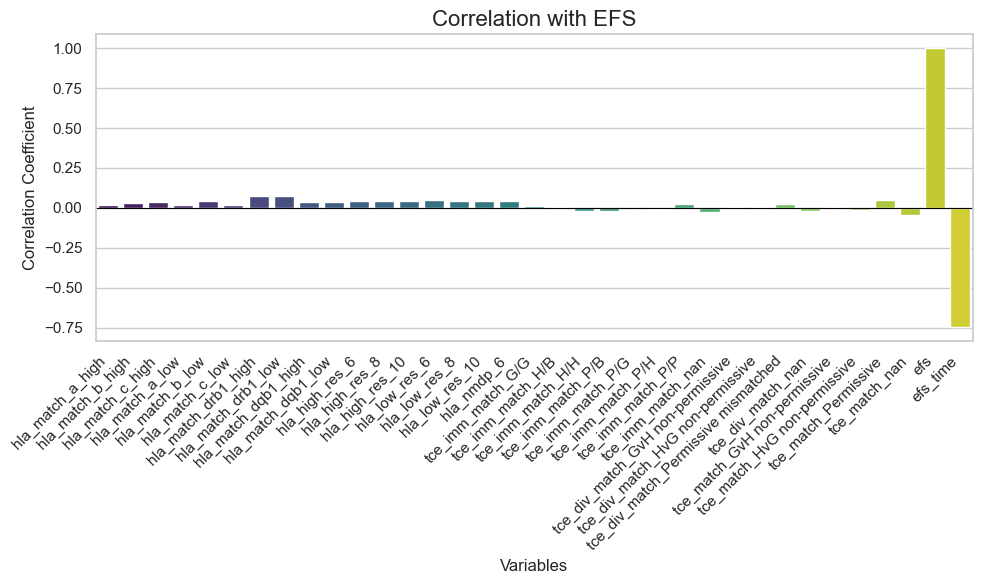

C:\Users\86198\AppData\Local\Temp\ipykernel_9232\4040851267.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=efs_time_corr.index, y=efs_time_corr.values, palette="viridis")


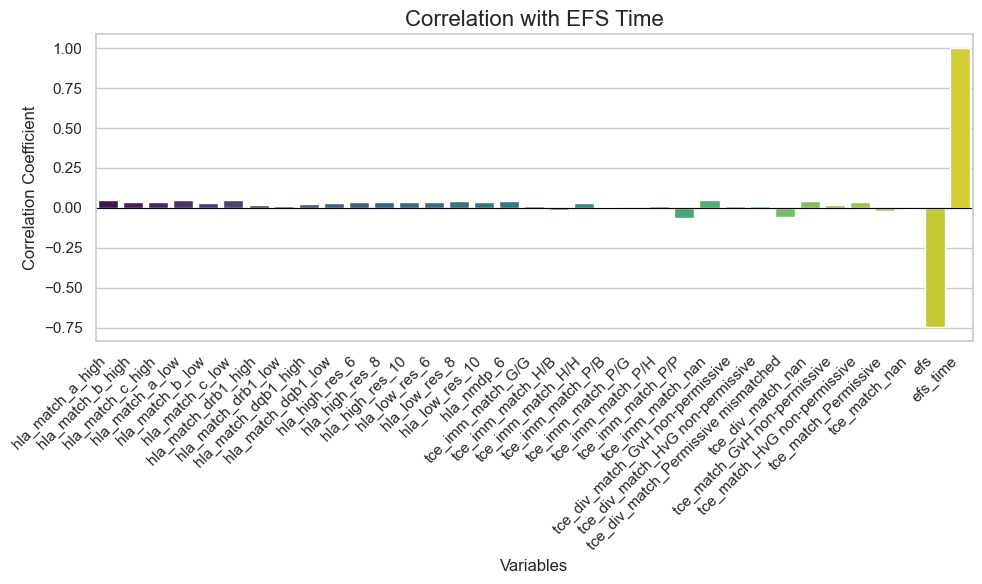

In [42]:

    # 计算与 efs 的相关性
    efs_corr = filtered_data[group_columns].corrwith(filtered_data['efs'])

    # 计算与 efs_time 的相关性
    efs_time_corr = filtered_data[group_columns].corrwith(filtered_data['efs_time'])

    # 设置图形风格
    sns.set(style="whitegrid")

    # 绘制 efs 相关性图
    plt.figure(figsize=(10, 6))
    sns.barplot(x=efs_corr.index, y=efs_corr.values, palette="viridis")
    plt.axhline(0, color="black", linewidth=0.8)  # 添加水平参考线
    plt.title("Correlation with EFS", fontsize=16)
    plt.xlabel("Variables", fontsize=12)
    plt.ylabel("Correlation Coefficient", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # 绘制 efs_time 相关性图
    plt.figure(figsize=(10, 6))
    sns.barplot(x=efs_time_corr.index, y=efs_time_corr.values, palette="viridis")
    plt.axhline(0, color="black", linewidth=0.8)  # 添加水平参考线
    plt.title("Correlation with EFS Time", fontsize=16)
    plt.xlabel("Variables", fontsize=12)
    plt.ylabel("Correlation Coefficient", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

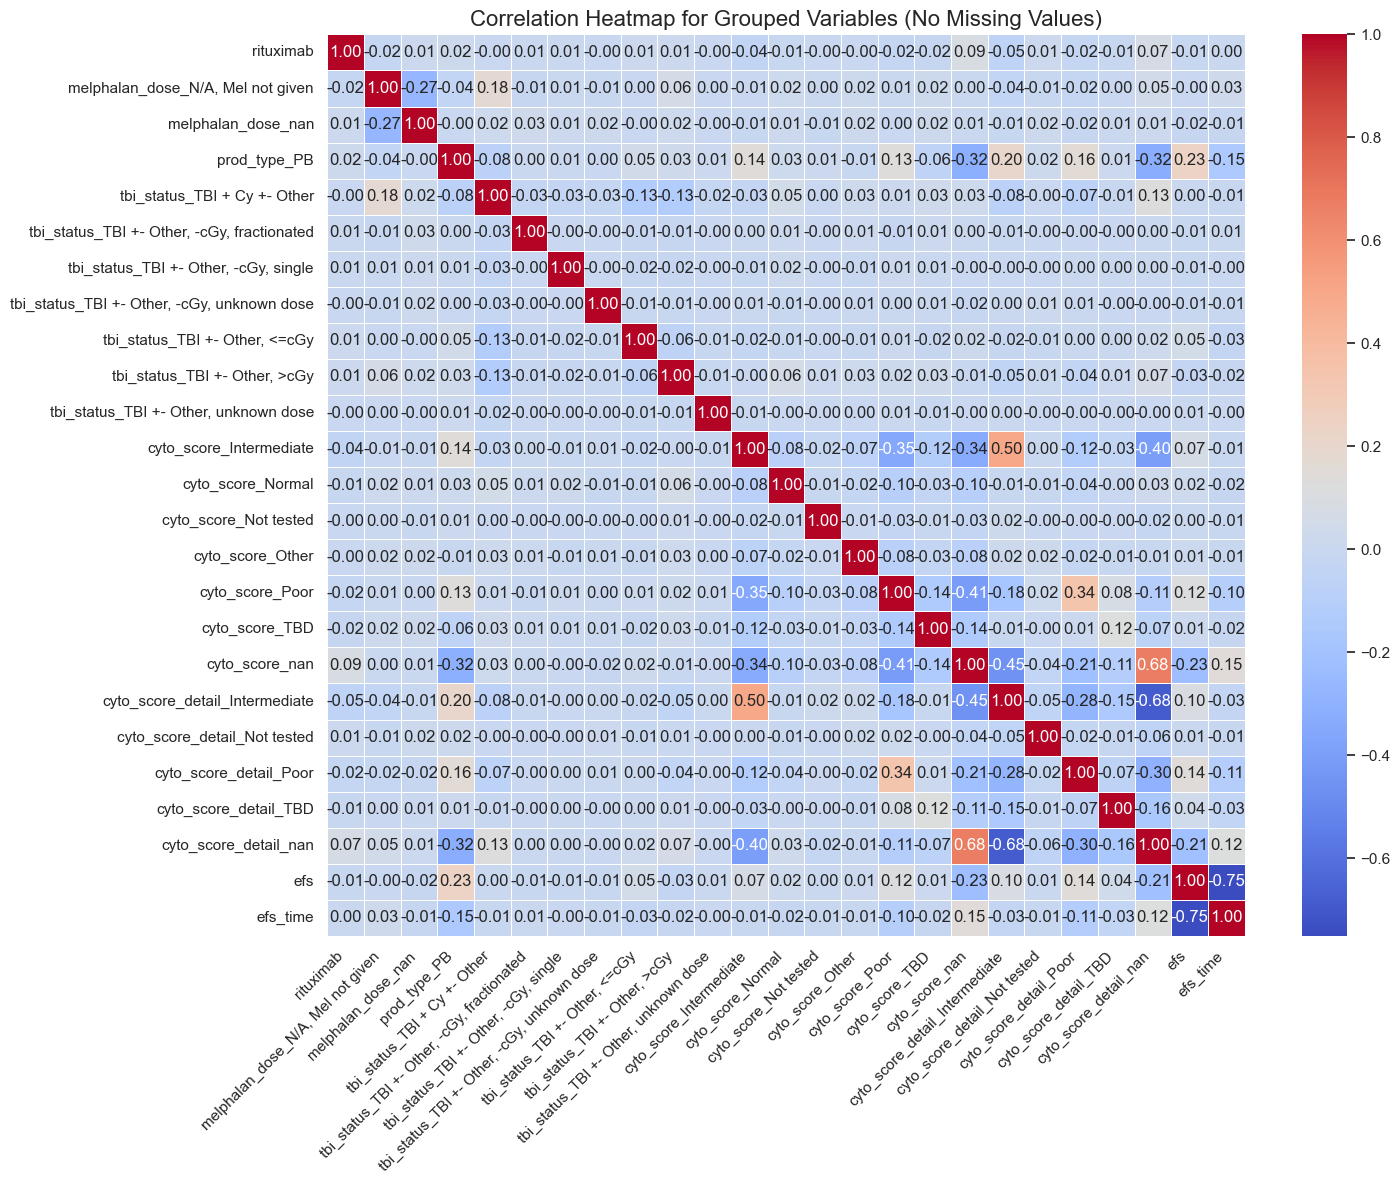

In [43]:

group_columns = [
    'rituximab',
    'melphalan_dose_N/A, Mel not given',
    'melphalan_dose_nan',
    'prod_type_PB',
     'tbi_status_TBI + Cy +- Other',
    'tbi_status_TBI +- Other, -cGy, fractionated',
    'tbi_status_TBI +- Other, -cGy, single',
    'tbi_status_TBI +- Other, -cGy, unknown dose',
    'tbi_status_TBI +- Other, <=cGy',
    'tbi_status_TBI +- Other, >cGy',
    'tbi_status_TBI +- Other, unknown dose',
    'cyto_score_Intermediate',
    'cyto_score_Normal',
    'cyto_score_Not tested',
    'cyto_score_Other',
    'cyto_score_Poor',
    'cyto_score_TBD',
    'cyto_score_nan',
    'cyto_score_detail_Intermediate',
'cyto_score_detail_Not tested',
'cyto_score_detail_Poor',
'cyto_score_detail_TBD',
'cyto_score_detail_nan','efs','efs_time'

]

# 删除包含 'Not done' 的行
data = data[~data.isin(['Not done']).any(axis=1)]

# 检查分组变量中是否有缺失值
data['gen'] = data[group_columns].isnull().any(axis=1).astype(int)

# 过滤数据：只保留没有缺失值的行
filtered_data = data[data['gen'] == 0].drop(columns=['gen'])

# 确保所有列都是数值型
filtered_data = filtered_data[group_columns].select_dtypes(include=['number'])

# 检查是否所有列都成功转换为数值型
if len(filtered_data.columns) != len(group_columns):
    missing_columns = [col for col in group_columns if col not in filtered_data.columns]
    print(f"Warning: Some columns were not included due to non-numeric data: {missing_columns}")

# 计算相关性矩阵
correlation_matrix = filtered_data.corr()

# 绘制热力图
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title("Correlation Heatmap for Grouped Variables (No Missing Values)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\86198\AppData\Local\Temp\ipykernel_9232\4040851267.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=efs_corr.index, y=efs_corr.values, palette="viridis")


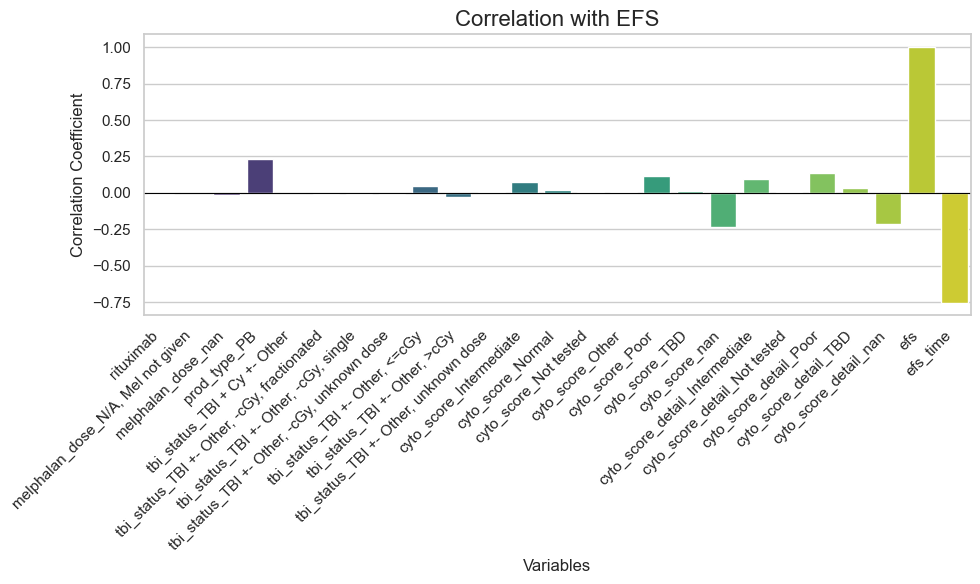

C:\Users\86198\AppData\Local\Temp\ipykernel_9232\4040851267.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=efs_time_corr.index, y=efs_time_corr.values, palette="viridis")


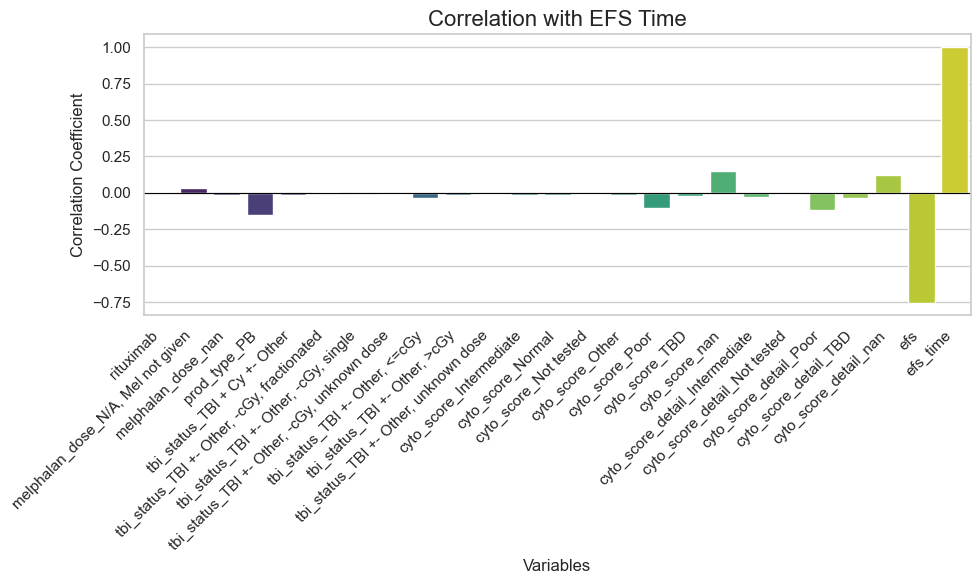

In [44]:

    # 计算与 efs 的相关性
    efs_corr = filtered_data[group_columns].corrwith(filtered_data['efs'])

    # 计算与 efs_time 的相关性
    efs_time_corr = filtered_data[group_columns].corrwith(filtered_data['efs_time'])

    # 设置图形风格
    sns.set(style="whitegrid")

    # 绘制 efs 相关性图
    plt.figure(figsize=(10, 6))
    sns.barplot(x=efs_corr.index, y=efs_corr.values, palette="viridis")
    plt.axhline(0, color="black", linewidth=0.8)  # 添加水平参考线
    plt.title("Correlation with EFS", fontsize=16)
    plt.xlabel("Variables", fontsize=12)
    plt.ylabel("Correlation Coefficient", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # 绘制 efs_time 相关性图
    plt.figure(figsize=(10, 6))
    sns.barplot(x=efs_time_corr.index, y=efs_time_corr.values, palette="viridis")
    plt.axhline(0, color="black", linewidth=0.8)  # 添加水平参考线
    plt.title("Correlation with EFS Time", fontsize=16)
    plt.xlabel("Variables", fontsize=12)
    plt.ylabel("Correlation Coefficient", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()